<a href="https://colab.research.google.com/github/vivek-bombatkar/MyLearningNotes/blob/master/ML/TF4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
# dataset = tf.data.Dataset.range(10)
# dataset = dataset.window(5, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(5))
# dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# dataset = dataset.shuffle(buffer_size=10)
# dataset = dataset.batch(2).prefetch(1)
# for x,y in dataset:
#   print("x = ", x.numpy())
#   print("y = ", y.numpy())

In [ ]:
ds = tf.data.Dataset.range(10)

In [ ]:
ds = ds.window(size=20, shift=1,stride =1, drop_remainder=True)

In [ ]:
ds = ds.flat_map(lambda window:)

TypeError: ignored

In [ ]:
ds = ds.map(lambda window: (window[:-1], window[-1:]))

In [ ]:
ds = ds.shuffle(buffer_size=10)

In [ ]:
ds = ds.batch(2).prefetch(1)

In [ ]:
for i,j in ds:
  print(i)

tf.Tensor(
[[4 5 6 7]
 [5 6 7 8]], shape=(2, 4), dtype=int64)
tf.Tensor(
[[3 4 5 6]
 [1 2 3 4]], shape=(2, 4), dtype=int64)
tf.Tensor(
[[2 3 4 5]
 [0 1 2 3]], shape=(2, 4), dtype=int64)


In [ ]:
# l0 = tf.keras.layers.Dense(1, input_shape=[20])
# model = tf.keras.models.Sequential([l0])

In [52]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
ds = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

NameError: ignored

In [ ]:
l0 = tf.keras.layers.Dense(1,input_shape=[20])
ts_model = tf.keras.models.Sequential([l0])

In [ ]:
ts_model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9),
    loss='mse',
    metrics=['accuracy']
)

In [51]:
ts_model.fit(ds,epochs=100,verbose=0)

TypeError: ignored

# RNN

In [53]:
import numpy as np

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [58]:
def trend(time, slope=0):
  return slope * time

In [61]:
def seasonal_pattern(season_time):
  return np.where(
      season_time < 0.4 ,
      np.cos(season_time * 2 * np.pi),
      1 / np.exp(3 * season_time)
  )

In [62]:
def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time + phase) % period )/ period
  return amplitude * seasonal_pattern(season_time)

In [64]:
def noise(time, noise_level=1 ,seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.random(len(time)) * noise_level

In [65]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [66]:
train_set = windowed_dataset(
    x_train,
    window_size,
    batch_size=128,
    shuffle_buffer = shuffle_buffer_size
)

In [68]:
train_set

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

1. model build

In [83]:
from tensorflow.keras import layers
rnn_model = tf.keras.models.Sequential([
                                        layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                        layers.SimpleRNN(40, return_sequences=True),
                                        layers.SimpleRNN(40),
                                        layers.Dense(1),
                                        layers.Lambda(lambda x: x * 100.0)
])

2. learning rate scheduler

In [84]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch / 20)
) 

3. optimizer

In [85]:
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

4. compile 

In [87]:
rnn_model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])

In [88]:
history = rnn_model.fit(train_set,
                        epochs=500,
                        callbacks=[lr_schedule])

Epoch 1/500
8/8 [==============================] - 2s 20ms/step - loss: 47.9658 - mae: 48.4658
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 47.3385 - mae: 47.8385
Epoch 3/500
8/8 [==============================] - 0s 16ms/step - loss: 47.5410 - mae: 48.0410
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 45.5348 - mae: 46.0348
Epoch 5/500
8/8 [==============================] - 0s 17ms/step - loss: 44.8185 - mae: 45.3185
Epoch 6/500
8/8 [==============================] - 0s 14ms/step - loss: 42.5724 - mae: 43.0724
Epoch 7/500
8/8 [==============================] - 0s 15ms/step - loss: 39.7488 - mae: 40.2488
Epoch 8/500
8/8 [==============================] - 0s 15ms/step - loss: 38.7202 - mae: 39.2202
Epoch 9/500
8/8 [==============================] - 0s 18ms/step - loss: 35.6417 - mae: 36.1417
Epoch 10/500
8/8 [==============================] - 0s 15ms/step - loss: 33.9913 - mae: 34.4913
Epoch 11/500
8/8 [==============================]

In [89]:
forcast=[]
for time in range(len(series) - window_size):
  forcast.append(rnn_model.predict(series[time:time + window_size][np.newaxis]))

In [79]:
import matplotlib.pyplot as plt

In [90]:
forcast = forcast[split_time - window_size : ]
result = np.array(forcast)[:,0,0]

In [81]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


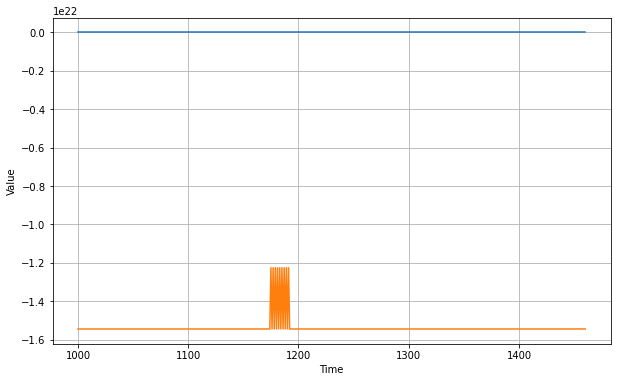

In [91]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,result)